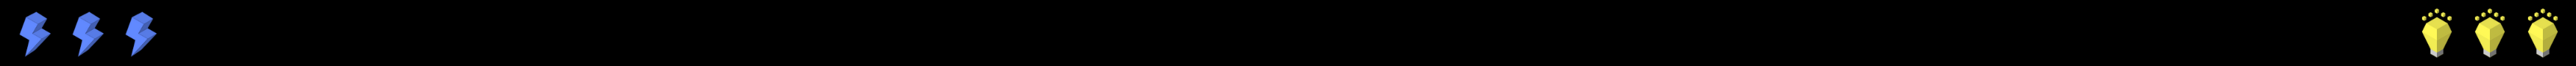

#### Import Packages.

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Data.

In [231]:
%%time
df1 = pd.read_excel("2017-2018.xlsx")
df2 = pd.read_excel("2019-2020.xlsx")
df3 = pd.read_excel("2021-2022.xlsx")
df4 = pd.read_excel("2023-2024.xlsx")

CPU times: total: 3.72 s
Wall time: 4.37 s


In [232]:
df1.head()

,Year,Date,Hourly Demand Met (in MW)
0,2018,01-Jan 12am,112591.48
1,2018,01-Jan 1am,109660.41
2,2018,01-Jan 2am,107696.63
3,2018,01-Jan 3am,106847.56
4,2018,01-Jan 4am,108517.07


In [233]:
file_paths = glob.glob("*.xlsx")
dataframes = [pd.read_excel(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

In [234]:
dataset = combined_data

In [235]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64248 entries, 0 to 64247
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       64248 non-null  int64  
 1   Date                       64248 non-null  object 
 2   Hourly Demand Met (in MW)  64248 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [236]:
dataset['Timestamp'] = dataset['Year'].astype(str) + "-" + dataset['Date'].astype(str)

In [237]:
dataset.head()

,Year,Date,Hourly Demand Met (in MW),Timestamp
0,2018,01-Jan 12am,112591.48,2018-01-Jan 12am
1,2018,01-Jan 1am,109660.41,2018-01-Jan 1am
2,2018,01-Jan 2am,107696.63,2018-01-Jan 2am
3,2018,01-Jan 3am,106847.56,2018-01-Jan 3am
4,2018,01-Jan 4am,108517.07,2018-01-Jan 4am


In [238]:
dataset = dataset.drop(columns = ['Year', 'Date'])

In [239]:
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])
dataset.dtypes

Hourly Demand Met (in MW)           float64
Timestamp                    datetime64[ns]
dtype: object

In [240]:
dataset.duplicated().sum()

np.int64(0)

In [241]:
dataset.shape

(64248, 2)

In [242]:
max_timestamp = dataset['Timestamp'].max()
min_timestamp = dataset['Timestamp'].min()
max_timestamp, min_timestamp

(Timestamp('2024-04-30 23:00:00'), Timestamp('2017-01-01 00:00:00'))

In [243]:
custom_timestamp = pd.date_range(start = min_timestamp, end = max_timestamp, freq = 'h')
custom_timestamp = pd.DataFrame(custom_timestamp, columns = ['Timestamp'])
custom_timestamp

,Timestamp
0,2017-01-01 00:00:00
1,2017-01-01 01:00:00
2,2017-01-01 02:00:00
3,2017-01-01 03:00:00
4,2017-01-01 04:00:00
...,...
64243,2024-04-30 19:00:00
64244,2024-04-30 20:00:00
64245,2024-04-30 21:00:00
64246,2024-04-30 22:00:00


In [244]:
dataset = custom_timestamp.merge(dataset, on = 'Timestamp', how = 'left')
dataset.shape

(64248, 2)

In [245]:
dataset.head()

,Timestamp,Hourly Demand Met (in MW)
0,2017-01-01 00:00:00,108985.17
1,2017-01-01 01:00:00,105856.08
2,2017-01-01 02:00:00,103115.75
3,2017-01-01 03:00:00,102407.04
4,2017-01-01 04:00:00,104235.34


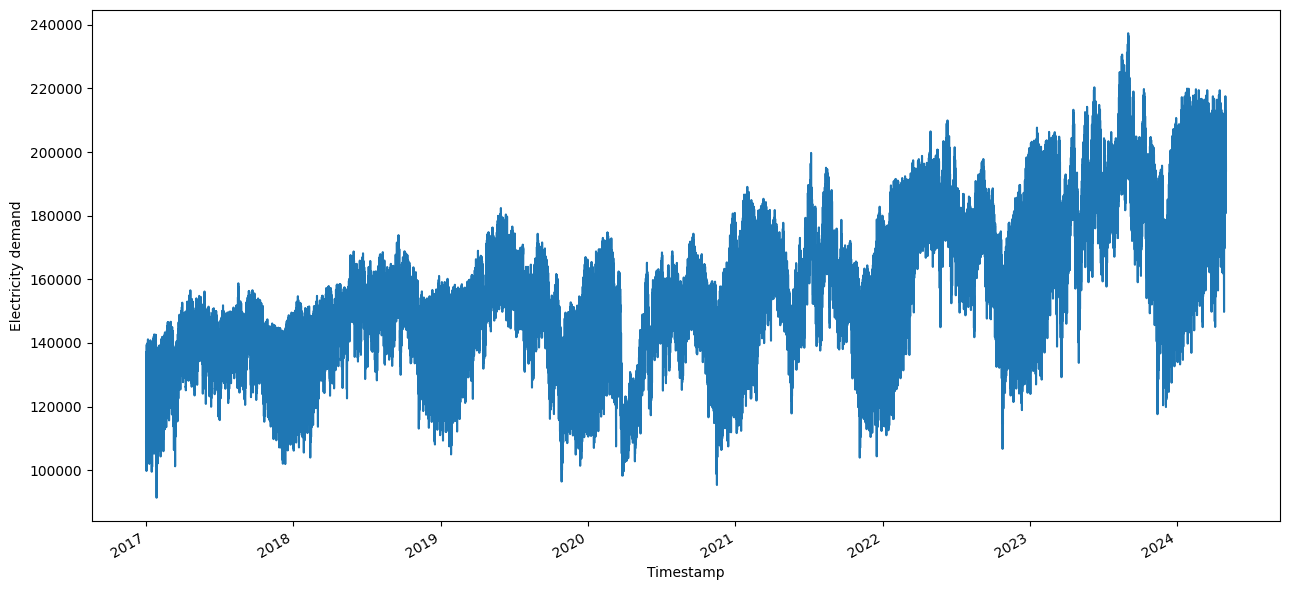

In [246]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(dataset['Timestamp'], dataset['Hourly Demand Met (in MW)'])
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity demand')

fig.autofmt_xdate()
plt.tight_layout()

#### Start with baseline model on sample data.

In [247]:
baseline_train = dataset[:1000]
baseline_test = dataset[1000:1101]

In [248]:
historical_baseline_mean = baseline_train['Hourly Demand Met (in MW)'].mean()
historical_baseline_mean

np.float64(124990.46753)

In [249]:
baseline_test = baseline_test.copy()
baseline_test.loc[:, 'pred_mean'] = historical_baseline_mean
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean
1000,2017-02-11 16:00:00,132049.67,124990.46753
1001,2017-02-11 17:00:00,132699.66,124990.46753
1002,2017-02-11 18:00:00,136494.41,124990.46753
1003,2017-02-11 19:00:00,139043.27,124990.46753
1004,2017-02-11 20:00:00,132069.83,124990.46753
...,...,...,...
1096,2017-02-15 16:00:00,133728.64,124990.46753
1097,2017-02-15 17:00:00,134944.64,124990.46753
1098,2017-02-15 18:00:00,139884.54,124990.46753
1099,2017-02-15 19:00:00,141681.55,124990.46753


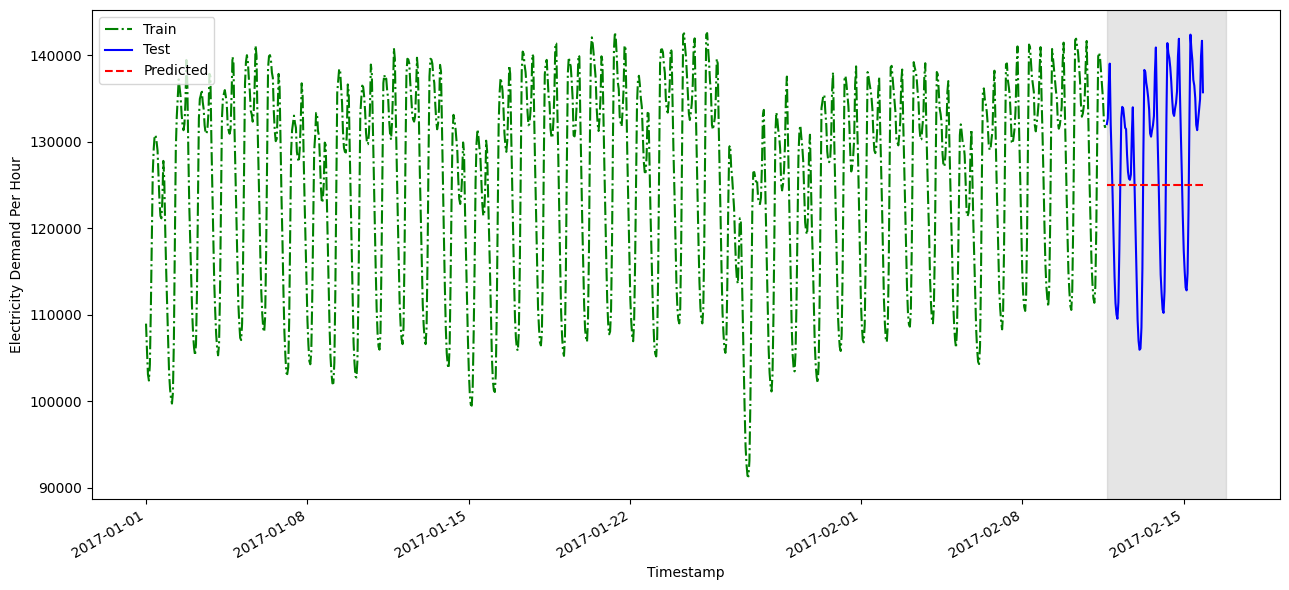

In [250]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
ax.plot(baseline_test['Timestamp'], baseline_test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [251]:
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [252]:
baseline_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['pred_mean'])
baseline_mape

np.float64(0.07502342693875343)

In [253]:
historical_lasthours_mean = baseline_train.loc[976 : 1000, 'Hourly Demand Met (in MW)'].mean()
historical_lasthours_mean

np.float64(129391.76291666667)

In [254]:
baseline_test.loc[:, 'lasthours_pred_mean'] = historical_lasthours_mean
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean,lasthours_pred_mean
1000,2017-02-11 16:00:00,132049.67,124990.46753,129391.762917
1001,2017-02-11 17:00:00,132699.66,124990.46753,129391.762917
1002,2017-02-11 18:00:00,136494.41,124990.46753,129391.762917
1003,2017-02-11 19:00:00,139043.27,124990.46753,129391.762917
1004,2017-02-11 20:00:00,132069.83,124990.46753,129391.762917
...,...,...,...,...
1096,2017-02-15 16:00:00,133728.64,124990.46753,129391.762917
1097,2017-02-15 17:00:00,134944.64,124990.46753,129391.762917
1098,2017-02-15 18:00:00,139884.54,124990.46753,129391.762917
1099,2017-02-15 19:00:00,141681.55,124990.46753,129391.762917


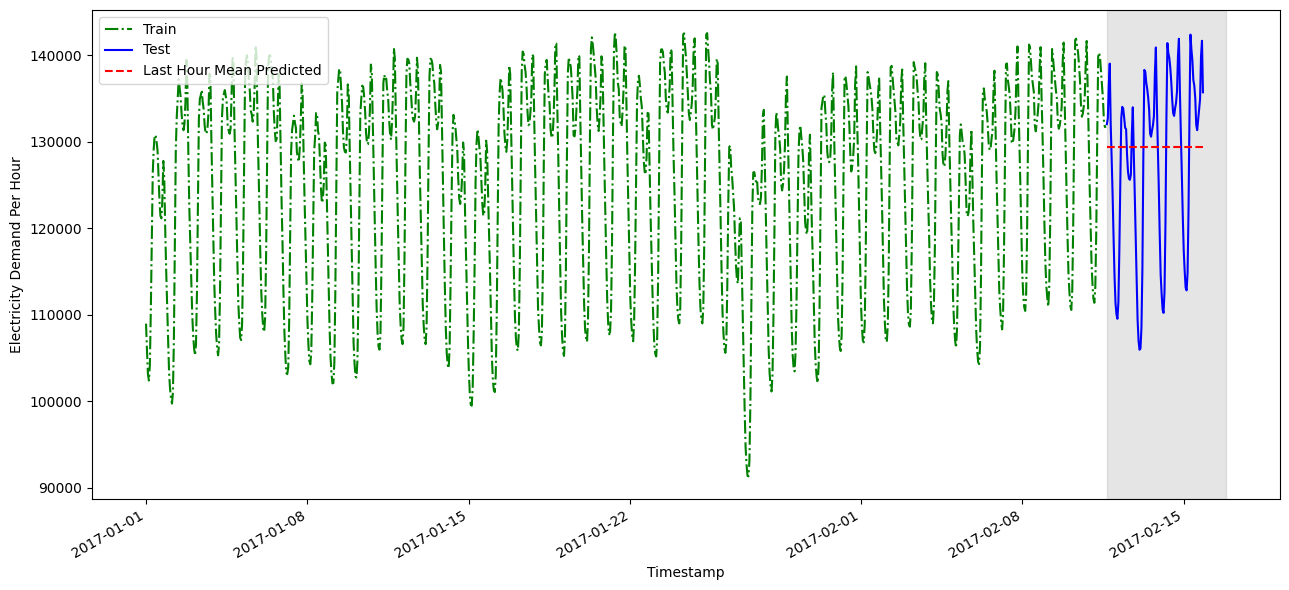

In [255]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
# ax.plot(baseline_test['Timestamp'], baseline_test['pred_mean'], 'r--', label='Mean Predicted')
ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_mean'], 'r--', label='Last Hour Mean Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [256]:
baseline_lasthour_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['lasthours_pred_mean'])
baseline_lasthour_mape

np.float64(0.0685467778453946)

In [257]:
baseline_test.loc[:, 'lasthours_pred_season'] = baseline_train['Hourly Demand Met (in MW)'][899 : 1000].values
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean,lasthours_pred_mean,lasthours_pred_season
1000,2017-02-11 16:00:00,132049.67,124990.46753,129391.762917,135232.87
1001,2017-02-11 17:00:00,132699.66,124990.46753,129391.762917,132881.66
1002,2017-02-11 18:00:00,136494.41,124990.46753,129391.762917,129955.84
1003,2017-02-11 19:00:00,139043.27,124990.46753,129391.762917,129805.65
1004,2017-02-11 20:00:00,132069.83,124990.46753,129391.762917,130597.44
...,...,...,...,...,...
1096,2017-02-15 16:00:00,133728.64,124990.46753,129391.762917,136423.18
1097,2017-02-15 17:00:00,134944.64,124990.46753,129391.762917,134859.44
1098,2017-02-15 18:00:00,139884.54,124990.46753,129391.762917,132199.44
1099,2017-02-15 19:00:00,141681.55,124990.46753,129391.762917,131707.65


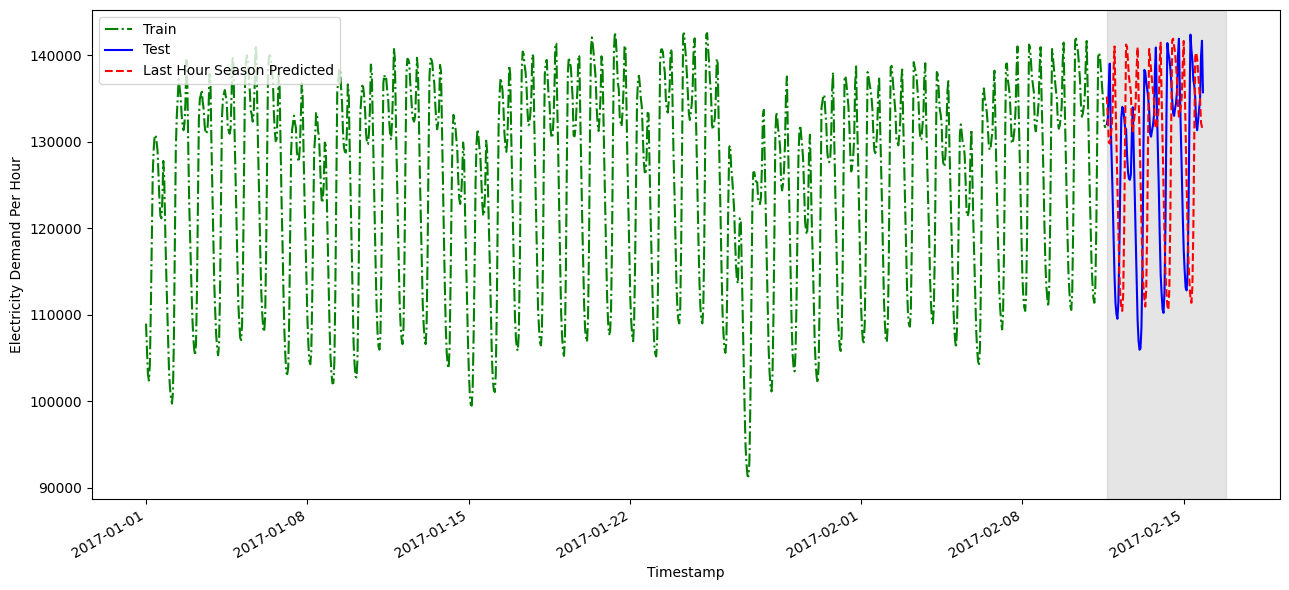

In [258]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
# ax.plot(baseline_test['Timestamp'], baseline_test['pred_mean'], 'r--', label='Mean Predicted')
# ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_mean'], 'r--', label='Last Hour Mean Predicted')
ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_season'], 'r--', label='Last Hour Season Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [259]:
baseline_lastseason_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['lasthours_pred_season'])
baseline_lastseason_mape

np.float64(0.09950514186555678)

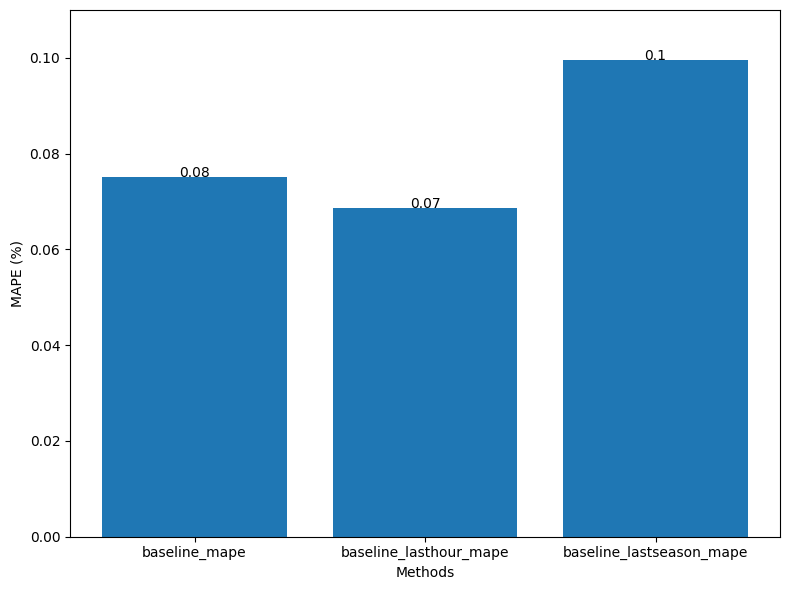

In [278]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

x = ['baseline_mape', 'baseline_lasthour_mape', 'baseline_lastseason_mape']
y = [baseline_mape, baseline_lasthour_mape, baseline_lastseason_mape]

ax.bar(x, y)
ax.set_xlabel('Methods')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.11)

for index, value in enumerate(y):
    ax.text(x=index, y=value, s=str(round(value,2)), ha='center')

plt.tight_layout()